# Sphere

Manifold
$$
\mathbb{S}^2 :=\left\{(x,y,z)\in \mathbb{R}^3\, :\, q(x,y,z) = 0\right\}
$$

Constraint function
$$
q(x, y, z) = (x-\mu_x)^2 + (y-\mu_y)^2 + (z-\mu_z)^2 - r^2
$$

Jacobian / gradient
$$
J_q(x, y, z) = 
\begin{pmatrix}
    2(x - \mu_x) \\
    2(y - \mu_y) \\
    2(z - \mu_z)
\end{pmatrix} = \nabla f(x,y,z) \in\mathbb{R}^{3\times 1}
$$

Parametric Equation
$$
\begin{align}
x &= \mu_x + r\sin\theta\cos\phi \\
y &= \mu_y + r\sin\theta\sin\phi \\
z &= \mu_z + r\cos\theta
\end{align}
$$

Tangent Basis via Parametric Equation
$$
\begin{align}
e_{\theta} &= \partial_\theta (x,y,z) = \left(r\cos\theta\cos\phi, r\cos\theta\sin\phi, -r\sin\theta\right) \\
e_{\phi} &= \partial_\phi (x, y, z) = \left(-r\sin\theta\sin\phi, r\sin\theta\cos\phi, 0\right)
\end{align}
$$

# Settings and Helper Functions

In [347]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
from numpy import pi
from scipy.stats import multivariate_normal, norm
import matplotlib.cm as cm
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import qr, svd
import plotly.express as px
import plotly.graph_objects as go

In [348]:
r = 1.0                          # Radius
n = 10000                        # Number of samples
m = 1                            # Number of constraints
d = 2                            # Dimension of manifold
mu = np.array([1.0, 2.0, 3.0])   # Center of the sphere
theta = 3.5                      # θ for initial point on the sphere
phi = 3.5                        # ϕ for initial point on the sphere
sigma = 0.5                      # σ scaling for proposal
tol = None                       # tolerance for root finding algorithm
a_guess = 1                      # initial guess for root-finding algorithm

In [349]:
# SPHERE
def to_cartesian(theta_phi):
    """[θ, ϕ] --> [x, y, z]"""
    theta, phi = theta_phi[0], theta_phi[1]
    x = mu[0] + r * np.cos(phi) * np.sin(theta)
    y = mu[1] + r * np.sin(phi) * np.sin(theta)
    z = mu[2] + r * np.cos(theta)
    return np.array([x, y, z])

# SPHERE
def grad(xyz):
    """Q"""
    return 2*xyz - 2*mu

def tb_param(theta, phi):
    """Computes basis of tangent space at a point identified by (theta, phi)."""
    et = np.array([
        r*np.cos(theta)*np.cos(phi),
        r*np.cos(theta)*np.sin(phi),
        -r*np.sin(theta)
    ])
    ep = np.array([
        -r*np.sin(theta)*np.sin(phi),
        r*np.sin(theta)*np.cos(phi),
        0
    ])
    return et, ep

def tangent_basis(Q):
    """Given the Q matrix (the gradient) computes a basis for the tagent space it is normal to via SVD"""
    U = svd(Q.reshape(-1, m))[0]
    return U[:, m:]   # contains 2 columns. Each column is a basis

# ANY
def normalize(x):
    """Returns x as a unit vector"""
    return x / np.sqrt(np.sum(x**2))

def project(x, v, Q, tol=None, a_guess=1):
    """Finds a such that q(x + v + a*Q) = 0"""
    opt_output = root(lambda a: q(x + v + a*Q), a_guess, tol=tol)
    return (opt_output.x, opt_output.success) # output flag for accept/reject

def logf(x):
    """Implements the target distribution on the manifold"""
    # In our case, it's the uniform distribution
    return 0

def log_proposal(v):
    """Computes log density of the proposal. Right now its a gaussian"""
    return multivariate_normal.logpdf(v, mean=np.zeros(d), cov=(sigma**2)*np.eye(d))

def q(xyz):
    """Constraint function for the sphere"""
    return np.sum((xyz - mu)**2) - r**2

# Checks

Get an initial point using $\theta$ and $\phi$ provided above and compute its gradient.

In [350]:
x = to_cartesian(np.array([theta, phi]))
g = grad(x)

Use the parametric formulas to obtain $e_{\theta}$ and $e_{\phi}$. Check that these are perpendicular to the gradient at $x$.

In [351]:
e_θ, e_ϕ = tb_param(theta, phi)
print(np.dot(e_θ, g), np.dot(e_ϕ, g))
print(np.sum(e_θ**2), np.sum(e_ϕ**2))

-1.1102230246251565e-16 -1.3877787807814457e-17
1.0 0.12304887282834767


Compute now basis on the tangent space using SVD. Basically we compute basis for transpose of null space. 

In [352]:
# Compute SVD of the Q matrix
U, Σ, Vt = svd(grad(x).reshape(-1, 1))
# The last m columns (here m=1) should be perpendicular to the gradient
U[:, 1:].T @ g

array([ 1.6653143e-17, -3.9017743e-16])

# Algorithm

In [353]:
# Initial point on the sphere
x = to_cartesian(np.array([theta, phi]))

# Store the n sampes on the manifold
samples = np.zeros((n, d+m))
samples[0, :] = x
i = 1

# Sample log-uniform variates for MH accept/reject step
logu = np.log(np.random.rand(n))

while i < n:
    
    # Compute gradient and bases at x
    Qx = grad(x)                 # Gradient at x (3,), 
    gx_basis = normalize(Qx)     # ON basis for gradient (3,)
    tx_basis = tangent_basis(Qx) # ON basis for tangent space at x using SVD (3, 2)
    
    # Sample along tangent
    v_sample = sigma*randn(d) # MVN with scaling σ
    v = tx_basis @ v_sample   # Multiply each basis vector with each MVN sample
    
    # Forward Projection
    a, flag = project(x, v, Qx, tol, a_guess)
    if flag == 0:              # Projection failed
        samples[i, :] = x      # Stay at x
        i += 1
        continue
    y = x + v + a*Qx           # Compute projected point
    
    # Compute v' and w' from y
    Qy = grad(y)                        # Gradient at y (3, )
    gy_basis = normalize(Qy)            # ON basis for gradient (3, )
    ty_basis = tangent_basis(Qy)        # ON basis for tangent space at y using SVD (3, 2)
    v_prime_sample = (x - y) @ ty_basis # Components along tangent
        
    # Metropolis-Hastings
    if logu[i] > logf(y) + log_proposal(v_prime_sample) - logf(x) - log_proposal(v_sample):
        samples[i, :] = x      # Reject, stay at x
        i += 1
        continue
    
    # Backward Projection
    v_prime = v_prime_sample @ ty_basis.T
    a_prime, flag = project(y, v_prime, Qy, tol, a_guess)
    if flag == 0:
        samples[i, :] = x     # projection failed, stay at x
        i += 1
        continue
        
    # Accept move
    x = y
    samples[i, :] = x
    i +=1

In [354]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=samples[:,0], 
            y=samples[:,1], 
            z=samples[:,2], 
            mode="markers",
            marker=dict(
                size=0.5,
                opacity=0.8
            ))
    ]
)
fig.show()

# Diagnostic - $\theta$ Marginal

In [355]:
# Centered samples
c_samples = (samples - mu)

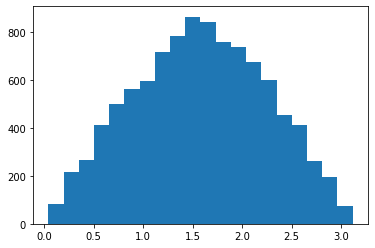

In [356]:
# Transforming (x,y,z) --> (θ, ϕ)
thetas = np.arccos(c_samples[:, 2])
_ = plt.hist(thetas, bins=20)

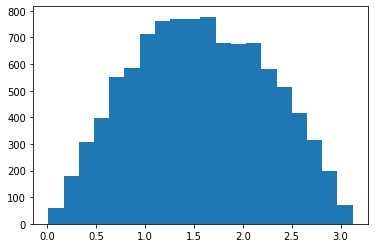

In [357]:
# Using geometrical arguments
ref = to_cartesian([2.0, 2.0])
thetas2 = 2*np.arccos(np.sqrt(np.sum((samples - ref)**2, axis=1)) / (2*r))
_ = plt.hist(thetas2, bins=20)

# Diagnostics - $\phi$ Marginal

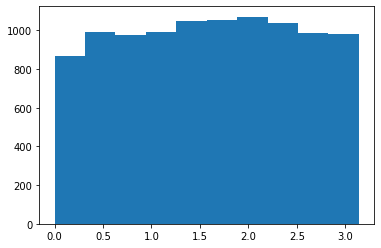

In [358]:
phis = np.arccos(c_samples[:, 0] / (r * np.sin(np.arccos(c_samples[:, 2]))))
_ = plt.hist(phis)